# 火影忍者結印影像辨識

### 組員:
財管四 105307030 陳韋勳<br>
應數一 108701016 洪晨維<br>
應數一 108701044 戴煜偉<br>
應數一 108701003 林均宥

## 1. 動機
如果想要成為一名強大的火影，修練S級忍術的結印是一條必經之路，更是我們這組成員的最終目標！<br>
然而問題出現了，我們知道了訓練的方法，卻沒有驗證結印正確性的工具。<br>
因此，我們這組希望能夠透過機器學習來判斷我們比出的結印的正確性。<br>


## 2. 參考程式碼及資料集來源
https://github.com/angry-coder-room/naruto-handsigns-predict-dl<br>
已徵求到作者程式碼以及圖片使用的授權!<br>
經剔除不合適的照片後，剩7799張，將其中6214張分成train檔，剩下1585張分成test檔<br>
GoogLeNet模型程式碼參考來源:https://www.twblogs.net/a/5b7aea082b7177392c971759

## 3. 模型選擇
 作者原本採用的模型是LeNet-5模型搭配AlexNet模型中避免overfitting的兩個方法: Data Augmentation & dropout，<br>
但因為作者的模型在測試資料檔中的準確率並不高，於是我們研究了幾個比較有名的CNN模型，<br>其中包括: LeNet, AlexNet, VGGNet以及GoogLeNet。<br>最後我們決定採用用GoogLeNet模型中的Inception V2
#### 我們從LeNet、AlexNet、VGGNet及GoogLeNet中挑選出GoogLeNet主要有兩個原因:<br><br> 1. 因為其結合了其他三者的長處並提出Inception這種創新的網路結構，能夠大量降維且預測能力更勝於其他模型。<br><br>2. GoogLeNet在2014年ImageNet挑戰賽(ILSVRC14)獲得第一名

## 4. GoogLeNet Inception V1模型介紹
參考來源:https://medium.com/%E5%AD%B8%E4%BB%A5%E5%BB%A3%E6%89%8D/googlenet-inception%E7%9A%84%E6%BC%94%E9%80%B2-f8a5641e99c3<br>

2014年GoogleNets被提出，它在ImageNet分類競賽打敗VGG。那時候的Inception Net稱為V1版本(2014)。相較於Alexnet或VGG，網絡深度設計不斷加深。Inception就是在廣度上增加，並使用不同的捲積核大小(3x3，5x5，1x1)，來提取不同的特徵。但隨之而來參數量太大問題，就是使用了1x1的捲積降維了。所以在V1的特點就是:<br>
* 加寬網路廣度，使用多種的捲積核來提取不同的特徵<br>
* 引入 1x1 的捲積層降維(降低計算)<br>
* 後面的全連接層(FC)全部替換成全局平均池(Global Average Pooling)<br>
* 中間層使用輔助分類節點（auxiliary classifiers）:<br>
目的是為了幫助網絡的收斂，這輔助單元的計算結果會乘以0.3當作補償，和最後的LOSS相加作後為最終損失函數來訓練網絡。從網路架構來看，是他有三個輸出。論文中解釋是為了避免梯度的消失，也可以視為做一個Ensemble 。

## 5. 分工:
* 陳韋勳: 資料處理取得授權與處理、建構GoogLeNet模型、報告撰寫
* 戴煜偉: 資料處理、比較模型
* 林均宥: 圖像化模型結果

## 6. 匯入建立模型所需套件

In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
import tensorflow.keras.metrics as metric
#from keras import backend as K
import os

## 7. 參數設置

In [2]:
NB_CLASS=8                #手勢類別個數
image_width, image_height = 64, 64      #影像長寬
LEARNING_RATE=0.01
DROPOUT=0.4
LRN2D_NORM=True                
batch_size=400
EPOCH= 1
DATA_FORMAT='channels_last'

#將資料分成三個檔案: train、valid、test，比例為8:1:1
train_data= r'C:\Users\User\Desktop\程式\AI-python\naruto-handsigns-predict-dl-master\Data\datasetTrain'
vaildation_data= r'C:\Users\User\Desktop\程式\AI-python\naruto-handsigns-predict-dl-master\Data\datasetValidation'
test_data= r'C:\Users\User\Desktop\程式\AI-python\naruto-handsigns-predict-dl-master\Data\datasetTest'

## 8. 使用ImageDataGenerator分別對tain、valid裡的資料進行數據增強

* rotation_range: 圖片隨機轉動的角度
* width_shift_range: 圖片隨機水平方向偏移
* height_shift_range: 圖片隨機垂直方向偏移
* shear_range: 錯切變換，讓X座標(或Y座標)保持不變，對應的Y座標(或X座標)按比例發生平移
* zoom_range: 讓圖片在長或寬的方向進行放大
* horizontal_flip: 圖片隨機水平翻轉
* flow_from_directory方法可以從相應的目錄裏面批量獲取圖片，這樣就可以不用一次性讀取所有圖片(防止內存不足)
* 參考來源: https://medium.com/ai%E5%8F%8D%E6%96%97%E5%9F%8E/preprocessing-data-image-data-augmentation%E5%AF%A6%E4%BD%9C%E8%88%87%E5%8F%83%E6%95%B8%E8%AA%AA%E6%98%8E-d05f2ed24194

In [3]:
#train data
train_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.3,                
    zoom_range=0.5,
    horizontal_flip=True,
)
train_generator = train_datagen.flow_from_directory(
  train_data,
  target_size=(image_width, image_height),
  batch_size=batch_size,color_mode="grayscale", class_mode='categorical'
)

#vaild data
vaild_datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.3,
    zoom_range=0.5,
    horizontal_flip=True,
)
vaild_generator = train_datagen.flow_from_directory(
  vaildation_data,
  target_size=(image_width, image_height),
  batch_size=batch_size,color_mode="grayscale", class_mode='categorical'
)

#test data
test_datagen = ImageDataGenerator()
test_generator = train_datagen.flow_from_directory(
  test_data,
  target_size=(image_width, image_height),
  batch_size=batch_size, color_mode="grayscale", class_mode='categorical'
)

Found 6214 images belonging to 8 classes.
Found 805 images belonging to 8 classes.
Found 780 images belonging to 8 classes.


## 9.  conv2D_lrn2d層 
### 新增一層Conv2D再將其輸出透過 BatchNormalization 防止模型過擬合<br><br> BatchNormalization: 減少了Internal Variance Shift。使得每一程的輸出的分佈都滿足指定的高斯分佈，<br>可以防止訓練集與測試集之間分佈的不匹配，還能加快網絡收斂速度，防止過度擬合。

In [4]:
# 先新增一層Conv2D再將其輸出透過 BatchNormalization 防止模型過擬合
# BatchNormalization: 減少了Internal Variance Shift。使得每一程的輸出的分佈都滿足指定的高斯分佈，可以防止訓練集與測試集之間分佈的不匹配，還能加快網絡收斂速度，防止過擬合。
def conv2D_lrn2d(x,filters,kernel_size,strides=(1,1),padding='same',activation='relu',data_format=DATA_FORMAT,lrn2d_norm=LRN2D_NORM):
    x=Conv2D(filters=filters,             
             kernel_size=kernel_size,     
             strides=strides,
             padding=padding,
             activation=activation,
             data_format=data_format)(x)
    if lrn2d_norm:
        #batch normalization: 來防止模型過擬合
        x=BatchNormalization()(x)

    return x



## 10. inception_module架構
### 如圖: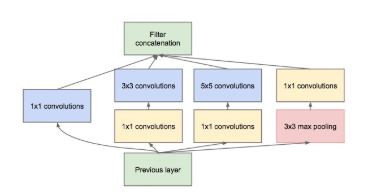

In [5]:
def inception_module(x,params,concat_axis,padding='same',activation='relu',data_format=DATA_FORMAT):
    (branch1,branch2,branch3,branch4)=params

    #1x1
    pathway1=Conv2D(filters=branch1[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,activation=activation)(x)

    #1x1->3x3
    pathway2=Conv2D(filters=branch2[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,activation=activation)(x)
    pathway2=Conv2D(filters=branch2[1],kernel_size=(3,3),strides=1,padding=padding,data_format=data_format,activation=activation)(pathway2)

    #1x1->5x5
    pathway3=Conv2D(filters=branch3[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,activation=activation)(x)
    pathway3=Conv2D(filters=branch3[1],kernel_size=(5,5),strides=1,padding=padding,data_format=data_format,activation=activation)(pathway3)

    #3x3->1x1
    pathway4=MaxPooling2D(pool_size=(3,3),strides=1,padding=padding)(x)
    pathway4=Conv2D(filters=branch4[0],kernel_size=(1,1),strides=1,padding=padding,data_format=data_format,activation=activation)(pathway4)

    return concatenate([pathway1,pathway2,pathway3,pathway4],axis=concat_axis)

## 11. create_model: 建造模型中的各層，如圖所示
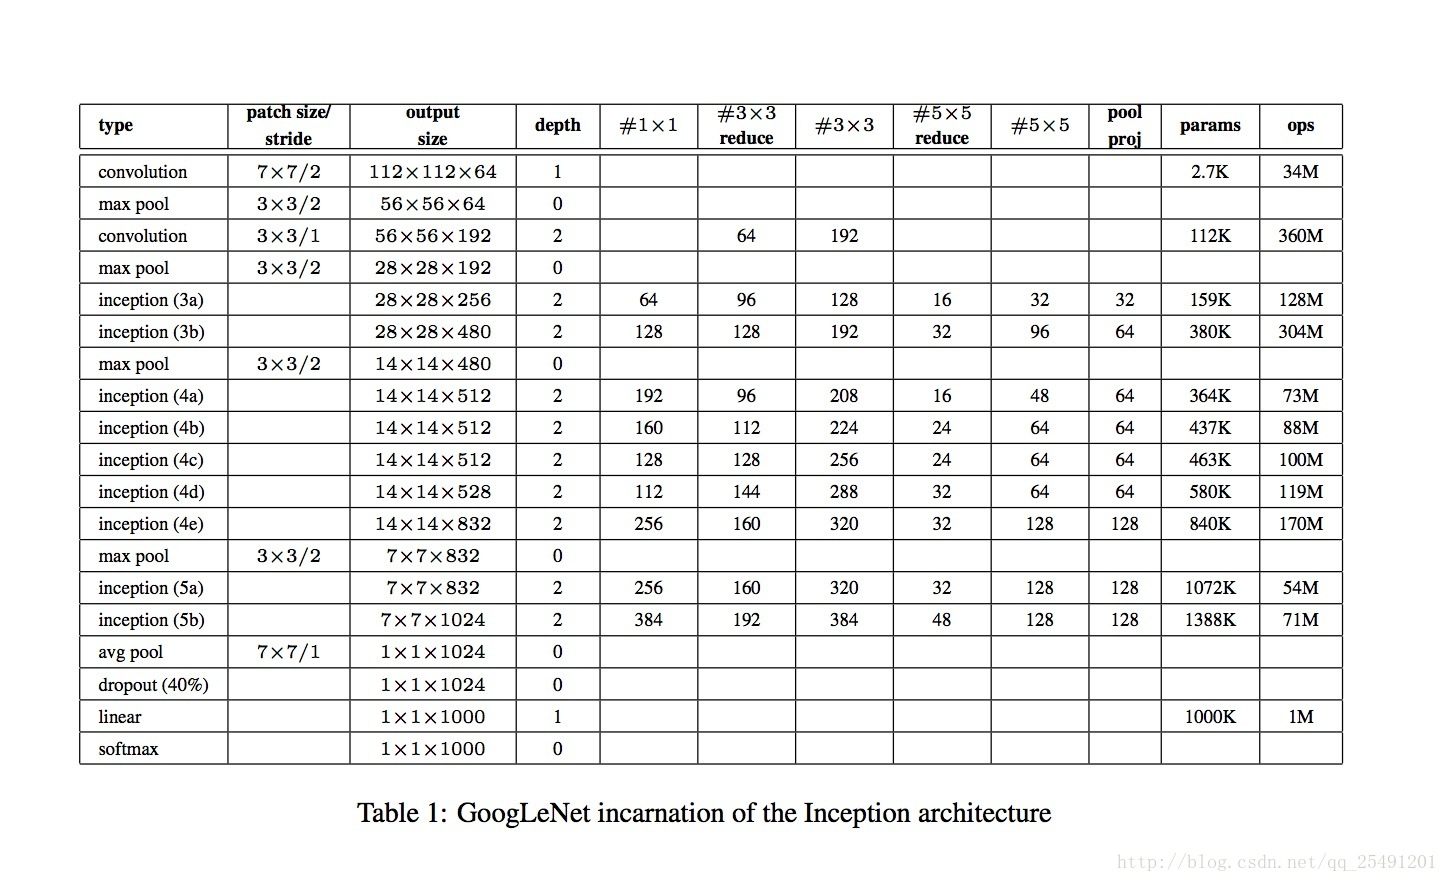
圖片來源: https://www.twblogs.net/a/5b7aea082b7177392c971759

In [6]:
def create_model():
    
    #處理data格式
    #channels_first=[batch，in_channels，in_height，in_width]    #batch:資料張數   in_channels:若為RGB，則=3
    #channels_last=[batch，in_height，in_with，in_channels]
    if DATA_FORMAT == 'channels_first':
        input_shape = (1, image_width, image_height)
        img_input=Input(shape=input_shape)
        CONCAT_AXIS=1
    else:
        input_shape = (image_width, image_height, 1)
        img_input=Input(shape=input_shape)
        CONCAT_AXIS=3
    
    #以下建構方式如上圖
    x=conv2D_lrn2d(img_input,64,(7,7),2,padding='same')
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)
    x=BatchNormalization()(x)

    x=conv2D_lrn2d(x,64,(1,1),1,padding='same')
    x=conv2D_lrn2d(x,192,(3,3),1,padding='same')
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)

    x=inception_module(x,params=[(64,),(96,128),(16,32),(32,)],concat_axis=CONCAT_AXIS) #3a
    x=inception_module(x,params=[(128,),(128,192),(32,96),(64,)],concat_axis=CONCAT_AXIS) #3b
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)
    
    x=inception_module(x,params=[(192,),(96,208),(16,48),(64,)],concat_axis=CONCAT_AXIS) #4a
    x=inception_module(x,params=[(160,),(112,224),(24,64),(64,)],concat_axis=CONCAT_AXIS) #4b
    x=inception_module(x,params=[(128,),(128,256),(24,64),(64,)],concat_axis=CONCAT_AXIS) #4c
    x=inception_module(x,params=[(112,),(144,288),(32,64),(64,)],concat_axis=CONCAT_AXIS) #4d
    x=inception_module(x,params=[(256,),(160,320),(32,128),(128,)],concat_axis=CONCAT_AXIS) #4e
    x=MaxPooling2D(pool_size=(3,3),strides=2,padding='same',data_format=DATA_FORMAT)(x)

    x=inception_module(x,params=[(256,),(160,320),(32,128),(128,)],concat_axis=CONCAT_AXIS) #5a
    x=inception_module(x,params=[(384,),(192,384),(48,128),(128,)],concat_axis=CONCAT_AXIS) #5b
    x=AveragePooling2D(pool_size=(1,1),strides=1,padding='valid',data_format=DATA_FORMAT)(x)

    x=Flatten()(x)
    x=Dropout(DROPOUT)(x)
    x=Dense(NB_CLASS,activation='linear')(x)
    x=Dense(NB_CLASS,activation='softmax')(x)

    return x,img_input,CONCAT_AXIS,input_shape,DATA_FORMAT

## 12. 執行模型並將各層參數揭露

In [7]:
def check_print():
    # Create the Model
    x,img_input,CONCAT_AXIS,input_shape,DATA_FORMAT=create_model()

    # Create a Keras Model
    model=Model(inputs=img_input,outputs=[x])
    model.summary()

    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc',metric.top_k_categorical_accuracy])
    return model

## 13. 主程式執行並儲存檔案

In [8]:
# 如果之前有執行過，就會再繼續執行，若沒有，就使用check_print()開始執行模型
if __name__=='__main__':
    if os.path.exists('inception_1.h5'):
        model=load_model('inception_1.h5')
    else:
        model=check_print()

    history = model.fit_generator(train_generator,validation_data=vaild_generator,epochs=EPOCH,steps_per_epoch=train_generator.n/batch_size
                        ,validation_steps=vaild_generator.n/batch_size)
    model.save('inception_1.h5')
    
    import json
    model_json = model.to_json()
    with open("model_in_json.json", "w") as json_file:
        json.dump(model_json, json_file)
        
    #model.metrics=['acc',metric.top_k_categorical_accuracy]
    loss,acc,top_acc=model.evaluate_generator(test_generator,steps=test_generator.n/batch_size)


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 15.535 steps, validate for 2.0125 steps
16/15 [==============================] - 186s 12s/step - loss: 0.1656 - acc: 0.9438 - top_k_categorical_accuracy: 0.9965 - val_loss: 2.7591 - val_acc: 0.6770 - val_top_k_categorical_accuracy: 0.9689
Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


## 14. 模型結果

In [9]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MODEL LOSS')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

<Figure size 640x480 with 1 Axes>

## 15. 使用pygame模組，對即時結印影像做判斷

In [10]:
import numpy as np
import operator
import cv2
import sys, os
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from PIL import Image
import pygame

pygame.init()
screen = pygame.display.set_mode((900,900),pygame.RESIZABLE)

CLIP_X1 = 160
CLIP_Y1 = 140
CLIP_X2 = 400
CLIP_Y2 = 360

with open('model_in_json.json','r') as f:
    model_json = json.load(f)
loaded_model = model_from_json(model_json)
loaded_model.load_weights('inception_1.h5')

cap = cv2.VideoCapture(0)

while True:
    _, FrameImage = cap.read()
    FrameImage = cv2.flip(FrameImage, 1)
    cv2.imshow("", FrameImage)
    cv2.rectangle(FrameImage, (CLIP_X1, CLIP_Y1), (CLIP_X2, CLIP_Y2), (0,255,0) ,1)

    ROI = FrameImage[CLIP_Y1:CLIP_Y2, CLIP_X1:CLIP_X2]
    ROI = cv2.resize(ROI, (64, 64)) 
    ROI = cv2.cvtColor(ROI, cv2.COLOR_BGR2GRAY)
    #ROI= cv2.add(ROI,np.array([40.0]))
    _, output = cv2.threshold(ROI, 100, 255, cv2.THRESH_BINARY) # adjust brightness
    
    SHOWROI = cv2.resize(ROI, (256, 256)) 
    _, output2 = cv2.threshold(SHOWROI, 100, 255, cv2.THRESH_BINARY)
    cv2.imshow("ROI", output2)
    
    result = loaded_model.predict(output.reshape(1, 64, 64, 1))
    predict =   { 'bird':    result[0][0],
                  'dragon':    result[0][1],    
                  'horse':    result[0][2],
                  'monkey':    result[0][3],
                  'dog':    result[0][3],
                  'ox':    result[0][5],
                  'serpent':    result[0][6],
                  'ram':    result[0][7],
                  }
    
    predict = sorted(predict.items(), key=operator.itemgetter(1), reverse=True)
    
    if(predict[0][1] == 1.0):
        predict_img  = pygame.image.load(os.getcwd() + '/images/' + predict[0][0] + '.png')
    else:
        predict_img  = pygame.image.load(os.getcwd() + '/images/nosign.png')
    predict_img = pygame.transform.scale(predict_img, (900, 900))
    screen.blit(predict_img, (0,0))
    pygame.display.flip()
    interrupt = cv2.waitKey(10)

    if interrupt & 0xFF == ord('q'): # esc key
        break
            
pygame.quit()
cap.release()
cv2.destroyAllWindows()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## 16. Pygame測試範例
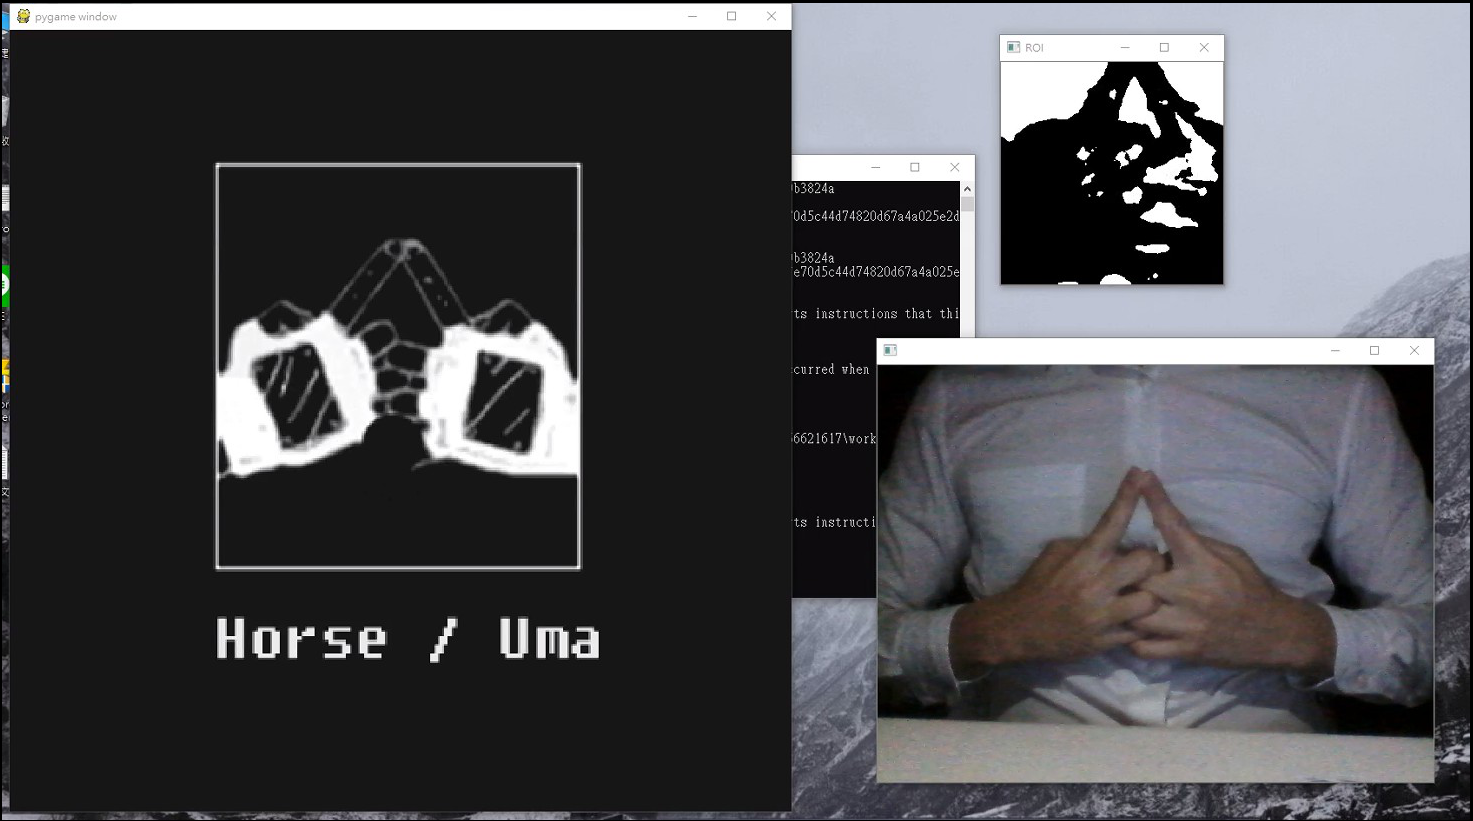

## 17. 結論
* 1. 採用的GooLenNet模型效果明顯優於作者原本的模型
* 2. 現在雖然只能判斷簡單8個手勢。但未來若能增加資料庫的豐富度，相信能給聽障人士帶來一大福音!

## 18. 改進
### Pygame執行效果不佳: 推測可能原因
* 1. 原本作者的資料雜訊過多 ->重新拍攝資料集
* 2. 採用黑白即時影像判斷很吃背景與燈光，因為背景必須是全白色，且燈光容易影響手勢形狀<br>(燈光過亮，無法判斷出手勢，燈光過暗則手勢顯示為全黑)  ->須研究其他判斷手勢的資料處理